# A2: NeuralNetwork Class

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Requirements" data-toc-modified-id="Requirements-1">Requirements</a></span></li><li><span><a href="#Code-for-NeuralNetwork-Class" data-toc-modified-id="Code-for-NeuralNetwork-Class-2">Code for <code>NeuralNetwork</code> Class</a></span></li><li><span><a href="#Example-Results" data-toc-modified-id="Example-Results-3">Example Results</a></span></li><li><span><a href="#Application-to-Boston-Housing-Data" data-toc-modified-id="Application-to-Boston-Housing-Data-4">Application to Boston Housing Data</a></span></li></ul></div>

## Requirements

In this assignment, you will complete the implementation of the `NeuralNetwork` class, starting with the code included in the next code cell.  Your implementation must meet the requirements described in the doc-strings.

Download [optimizers.tar](https://www.cs.colostate.edu/~anderson/cs545/notebooks/optimizers.tar) and extract `optimizers.py` for use in this assignment.

Then apply your `NeuralNetwork` class to the problem of predicting the value of houses in Boston as described below.

## Code for `NeuralNetwork` Class

In [4]:
%%writefile NeuralNetwork.py

import numpy as np
import optimizers as opt


class NeuralNetwork():
    """
    A class that represents a neural network for nonlinear regression

    Attributes
    ----------
    n_inputs : int
        The number of values in each sample
    n_hidden_units_by_layers: list of ints, or empty
        The number of units in each hidden layer.
        Its length specifies the number of hidden layers.
    n_outputs: int
        The number of units in output layer
    all_weights : one-dimensional numpy array
        Contains all weights of the network as a vector
    Ws : list of two-dimensional numpy arrays
        Contains matrices of weights in each layer,
        as views into all_weights
    all_gradients : one-dimensional numpy array
        Contains all gradients of mean square error with
        respect to each weight in the network as a vector
    Grads : list of two-dimensional numpy arrays
        Contains matrices of gradients weights in each layer,
        as views into all_gradients
    total_epochs : int
        Total number of epochs trained so far
    error_trace : list
        Mean square error (standardized) after each epoch
    X_means : one-dimensional numpy array
        Means of the components, or features, across samples
    X_stds : one-dimensional numpy array
        Standard deviations of the components, or features, across samples
    T_means : one-dimensional numpy array
        Means of the components of the targets, across samples
    T_stds : one-dimensional numpy array
        Standard deviations of the components of the targets, across samples
        
    Methods
    -------
    make_weights_and_views(shapes)
        Creates all initial weights and views for each layer

    train(X, T, n_epochs, method='sgd', learning_rate=None, verbose=True)
        Trains the network using samples by rows in X and T

    use(X)
        Applies network to inputs X and returns network's output
    """

    def __init__(self, nip, nhubl, nop):
        """Creates a neural network with the given structure

        Parameters
        ----------
        n_inputs : int
            The number of values in each sample
        n_hidden_units_by_layers : list of ints, or empty
            The number of units in each hidden layer.
            Its length specifies the number of hidden layers.
        n_outputs : int
            The number of units in output layer

        Returns
        -------
        NeuralNetwork object
        """

        # Assign attribute values. Set self.X_means to None to indicate
        # that standardization parameters have not been calculated.
        # ....
        self.nip=nip
        if not isinstance(nhubl, list):
            raise Exception('number of hidden units by layers must be a list.')
        self.nhubl=nhubl
        self.nop=nop
        self.X_means=None
        self.X_stds=None
        self.T_means=None
        self.T_stds=None
        self.total_epoch=None
        self.error_trace=None
          

        # Build list of shapes for weight matrices in each layer
        # ...
        Sow = []
        if(len(self.nhubl)):
            Sow.append((self.nip+1,nhubl[0]))
            for i in range(len(self.nhubl)):
                Sow.append((self.nhubl[i]+1,self.nhubl[i+1] if i+1<len(self.nhubl) else self.nop))
        else:
            Sow.append((self.nip+1,self.nop))
            
        
        # Call make_weights_and_views to create all_weights and Ws
        # ...
        self.all_weights,self.Wm=self.make_weights_and_views(Sow)
        
        
        # Call make_weights_and_views to create all_gradients and Grads
        # ...
        self.Agrad,self.grad=self.make_weights_and_views(Sow)

    def make_weights_and_views(self,Sow):
        """Creates vector of all weights and views for each layer

        Parameters
        ----------
        shapes : list of pairs of ints
            Each pair is number of rows and columns of weights in each layer

        Returns
        -------
        Vector of all weights, and list of views into this vector for each layer
        """

        # Create one-dimensional numpy array of all weights with random initial values
        #  ...
        Law=0
        for i in range(len(Sow)):
            Law+=Sow[i][0]*Sow[i][1]
        all_weights=(np.random.uniform(-1,1,Law)).flat/np.sqrt(self.nip+self.nop)
        
        # Build list of views by reshaping corresponding elements
        # from vector of all weights into correct shape for each layer.        
        # ...
        Wm=[]
        j=0
        for i in range(len(Sow)):
            Mlc=Sow[i][0]*Sow[i][1]
            Wm.append(all_weights[j:j+Mlc].reshape(Sow[i][0],Sow[i][1]))
            j=j+Mlc
            
        return all_weights,Wm

    def __repr__(self):
        return f'NeuralNetwork({self.n_inputs}, ' + \
            f'{self.n_hidden_units_by_layers}, {self.n_outputs})'

    def __str__(self):
        s = self.__repr__()
        if self.total_epochs > 0:
            s += f'\n Trained for {self.total_epochs} epochs.'
            s += f'\n Final standardized training error {self.error_trace[-1]:.4g}.'
        return s
 
    def train(self, X, T, n_epochs, method='sgd', learning_rate=None, verbose=True):
        """Updates the weights 

        Parameters
        ----------
        X : two-dimensional numpy array
            number of samples  x  number of input components
        T : two-dimensional numpy array
            number of samples  x  number of output components
        n_epochs : int
            Number of passes to take through all samples
        method : str
            'sgd', 'adam', or 'scg'
        learning_rate : float
            Controls the step size of each update, only for sgd and adam
        verbose: boolean
            If True, progress is shown with print statements
        """

        # Calculate and assign standardization parameters
        # ...
        self.X_means=np.mean(X,axis=0)
        self.X_stds=np.std(X,axis=0)
        self.T_means=np.mean(T,axis=0)
        self.T_stds=np.std(T,axis=0)

        # Standardize X and T
        # ...
        XS=(X-self.X_means)/self.X_stds
        TS=(T-self.T_means)/self.T_stds

        # Instantiate Optimizers object by giving it vector of all weights
        optimizer = opt.Optimizers(self.all_weights)

        error_convert_f = lambda err: (np.sqrt(err) * self.T_stds)[0]
        
        # Call the requested optimizer method to train the weights.
        self.total_epochs=n_epochs
        self.error_trace=[]


        if method == 'sgd':

            error_trace=optimizer.sgd(self.error_f,self.gradient_f,[XS,TS],n_epochs,0.01,True,error_convert_f,False,None)

        elif method == 'adam':

            error_trace=optimizer.adam(self.error_f,self.gradient_f,[XS,TS],n_epochs,learning_rate,verbose,error_convert_f,None)

        elif method == 'scg':

            error_trace=optimizer.scg(self.error_f,self.gradient_f,[XS,TS],n_epochs,error_convert_f,True,None)

        else:
            raise Exception("method must be 'sgd', 'adam', or 'scg'")

        self.total_epochs += len(error_trace)
        self.error_trace += error_trace

        # Return neural network object to allow applying other methods
        # after training, such as:    Y = nnet.train(X, T, 100, 0.01).use(X)

        return self

    def _forward(self, X):
        """Calculate outputs of each layer given inputs in X
        
        Parameters
        ----------
        X : input samples, standardized

        Returns
        -------
        Outputs of all layers as list
        """
        self.Ys = [X]
        # Append output of each layer to list in self.Ys, then return it.
        # ...
        for layeri in range(len(self.Wm)):
            self.Ys.append(np.tanh(self.Ys[layeri]@self.Wm[layeri][1:,:]+self.Wm[layeri][0:1,:]))
                           
        self.Ys.append(self.Ys[layeri]@self.Wm[-1][1:,:]+self.Wm[-1][0:1,:])
        
        return self.Ys

    # Function to be minimized by optimizer method, mean squared error
    def error_f(self, X, T):
        """Calculate output of net and its mean squared error 

        Parameters
        ----------
        X : two-dimensional numpy array
            number of samples  x  number of input components
        T : two-dimensional numpy array
            number of samples  x  number of output components

        Returns
        -------
        Mean square error as scalar float that is the mean
        square error over all samples
        """
        # Call _forward, calculate mean square error and return it.
        # ...
        Y_forwardpass=self._forward(X)
        mean_square_error = np.mean((T-Y_forwardpass[-1])**2)
        return mean_square_error

    # Gradient of function to be minimized for use by optimizer method
    def gradient_f(self, X, T):
        """Returns gradient wrt all weights. Assumes _forward already called.

        Parameters
        ----------
        X : two-dimensional numpy array
            number of samples  x  number of input components
        T : two-dimensional numpy array
            number of samples  x  number of output components

        Returns
        -------
        Vector of gradients of mean square error wrt all weights
        """

        # Assumes forward_pass just called with layer outputs saved in self.Ys.
        nos = X.shape[0]
        nop = T.shape[1]
        nol = len(self.nhubl) + 1

        # D is delta matrix to be back propagated
        D = -(T - self.Ys[-1]) / (nos * nop)

        # Step backwards through the layers to back-propagate the error (D)
        for layeri in range(nol - 1, -1, -1):
            # gradient of all but bias weights
            self.grad[layeri][1:, :] = self.Ys[layeri].T @ D
            # gradient of just the bias weights
            self.grad[layeri][0:1, :] = np.sum(D, axis=0)
            # Back-propagate this layer's delta to previous layer
            if layeri > 0:
                D = (D @ self.Wm[layeri][1:,:].T)*(1-self.Ys[layeri]**2)

        return self.Agrad

    def use(self, X):
        """Return the output of the network for input samples as rows in X

        Parameters
        ----------
        X : two-dimensional numpy array
            number of samples  x  number of input components, unstandardized

        Returns
        -------
        Output of neural network, unstandardized, as numpy array
        of shape  number of samples  x  number of outputs
        """

        # Standardize X
        # ...
        X_means=np.mean(X,axis=0)
        X_stds=np.std(X,axis=0)
        XS=(X-X_means)/X_stds
        YS=self._forward(XS)
        # Unstandardize output Y before returning it
        Y=YS[-1]*self.T_stds+self.T_means
        return Y

    def get_error_trace(self):
        """Returns list of standardized mean square error for each epoch"""
        return self.error_trace

Overwriting NeuralNetwork.py


## Example Results

Here we test the `NeuralNetwork` class with some simple data.  



method is sgd and rho is 0.01

sgd: Epoch 1 ObjectiveF=0.56994
sgd: Epoch 2 ObjectiveF=0.56994
sgd: Epoch 3 ObjectiveF=0.56994
sgd: Epoch 4 ObjectiveF=0.56994
sgd: Epoch 5 ObjectiveF=0.56994
sgd: Epoch 6 ObjectiveF=0.56994
sgd: Epoch 7 ObjectiveF=0.56993
sgd: Epoch 8 ObjectiveF=0.56993
sgd: Epoch 9 ObjectiveF=0.56993
sgd: Epoch 10 ObjectiveF=0.56993

method is adam and rho is 0.005

Adam: Epoch 1 ObjectiveF=0.56994
Adam: Epoch 2 ObjectiveF=0.56992
Adam: Epoch 3 ObjectiveF=0.56991
Adam: Epoch 4 ObjectiveF=0.56992
Adam: Epoch 5 ObjectiveF=0.56992
Adam: Epoch 6 ObjectiveF=0.56992
Adam: Epoch 7 ObjectiveF=0.56992
Adam: Epoch 8 ObjectiveF=0.56991
Adam: Epoch 9 ObjectiveF=0.56990
Adam: Epoch 10 ObjectiveF=0.56988

method is scg and rho is None

SCG: Epoch 1 ObjectiveF=0.56991
SCG: Epoch 2 ObjectiveF=0.56991
SCG: Epoch 3 ObjectiveF=0.56991
SCG: Epoch 4 ObjectiveF=0.56991
SCG: Epoch 5 ObjectiveF=0.56991
SCG: Epoch 6 ObjectiveF=0.56987
SCG: Epoch 7 ObjectiveF=0.56932
SCG: Epoch 8 ObjectiveF=0.

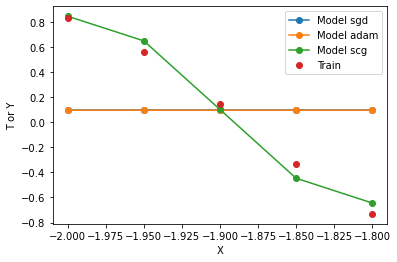

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import neuralnetwork as nn

X = np.arange(-2, 2, 0.05).reshape(-1, 1)
T = np.sin(X) * np.sin(X * 10)

# Just use first 5 samples
X = X[:5, :]
T = T[:5, :]

errors = []
# n_epochs = 1000
n_epochs = 10

method_rhos = [('sgd', 0.01),
               ('adam', 0.005),
               ('scg', None)]

for method, rho in method_rhos:
    
    print('\n=========================================')
    print(f'method is {method} and rho is {rho}')
    print('=========================================\n')

    nnet = nn.NeuralNetwork(X.shape[1], [2, 2], 1)
    
    # Set all weights here to allow comparison of your calculations
    # Must use [:] to overwrite values in all_weights.
    # Without [:], new array is assigned to self.all_weights, so self.Ws no longer refer to same memory
    nnet.all_weights[:] = np.arange(len(nnet.all_weights)) * 0.001
    
    nnet.train(X, T, n_epochs, method=method, learning_rate=rho)
    Y = nnet.use(X)
    plt.plot(X, Y, 'o-', label='Model ' + method)
    errors.append(nnet.get_error_trace())

plt.plot(X, T, 'o', label='Train')
plt.xlabel('X')
plt.ylabel('T or Y')
plt.legend();

sgd: Epoch 5000 ObjectiveF=0.53516
sgd: Epoch 10000 ObjectiveF=0.41235
sgd: Epoch 15000 ObjectiveF=0.38657
sgd: Epoch 20000 ObjectiveF=0.38638
sgd: Epoch 25000 ObjectiveF=0.38629
sgd: Epoch 30000 ObjectiveF=0.38623
sgd: Epoch 35000 ObjectiveF=0.38620
sgd: Epoch 40000 ObjectiveF=0.38618
sgd: Epoch 45000 ObjectiveF=0.38617
sgd: Epoch 50000 ObjectiveF=0.38616
Adam: Epoch 5000 ObjectiveF=0.20889
Adam: Epoch 10000 ObjectiveF=0.20809
Adam: Epoch 15000 ObjectiveF=0.20899
Adam: Epoch 20000 ObjectiveF=0.20795
Adam: Epoch 25000 ObjectiveF=0.20791
Adam: Epoch 30000 ObjectiveF=0.20881
Adam: Epoch 35000 ObjectiveF=0.20802
Adam: Epoch 40000 ObjectiveF=0.20783
Adam: Epoch 45000 ObjectiveF=0.20795
Adam: Epoch 50000 ObjectiveF=0.20787
SCG: Epoch 5000 ObjectiveF=0.00639
SCG: Epoch 10000 ObjectiveF=0.00212
SCG: Epoch 15000 ObjectiveF=0.00179
SCG: Epoch 20000 ObjectiveF=0.00168
SCG: Epoch 25000 ObjectiveF=0.00158
SCG: Epoch 30000 ObjectiveF=0.00148
SCG: Epoch 35000 ObjectiveF=0.00142
SCG: Epoch 40000 Obje

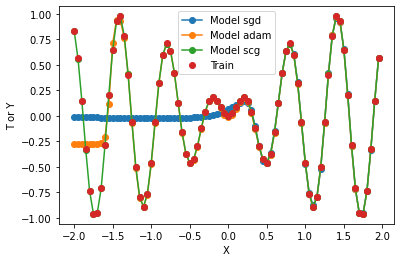

In [20]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import neuralnetwork as nn

X = np.arange(-2, 2, 0.05).reshape(-1, 1)
T = np.sin(X) * np.sin(X * 10)

errors = []
n_epochs = 1000
method_rhos = [('sgd', 0.01),
               ('adam', 0.01),
               ('scg', None)]

for method, rho in method_rhos:
    nnet = nn.NeuralNetwork(X.shape[1], [10, 10], 1)
    nnet.train(X, T, 50000, method=method, learning_rate=rho)
    Y = nnet.use(X)
    plt.plot(X, Y, 'o-', label='Model ' + method)
    errors.append(nnet.get_error_trace())

plt.plot(X, T, 'o', label='Train')
plt.xlabel('X')
plt.ylabel('T or Y')
plt.legend();

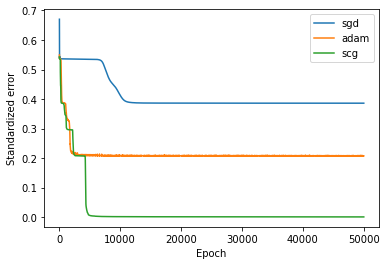

In [21]:
plt.figure(2)
plt.clf()
for error_trace in errors:
    plt.plot(error_trace)
plt.xlabel('Epoch')
plt.ylabel('Standardized error')
plt.legend([mr[0] for mr in method_rhos]);

Your results will not be the same, but your code should complete and make plots somewhat similar to these.

## Application to Boston Housing Data

Download data from [Boston House Data at Kaggle](https://www.kaggle.com/fedesoriano/the-boston-houseprice-data). Read it into python using the `pandas.read_csv` function.  Assign the first 13 columns as inputs to `X` and the final column as target values to `T`.  Make sure `T` is two-dimensional.

Before training your neural networks, partition the data into training and testing partitions, as shown here.

In [7]:
def partition(X, T, train_fraction):
    n_samples = X.shape[0]
    rows = np.arange(n_samples)
    np.random.shuffle(rows)
    
    ntrain = round(n_samples * train_fraction)
    
    Xtrain = X[rows[:ntrain], :]
    Ttrain = T[rows[:ntrain], :]
    Xtest = X[rows[ntrain:], :]
    Ttest = T[rows[ntrain:], :]
    return Xtrain,Ttrain,Xtest,Ttest
    
def rmse(T, Y):
    return np.sqrt(np.mean((T - Y)**2))

In [23]:
# Assuming you have assigned `X` and `T` correctly.

#Xtrain, Train, Xtest, Ttest = partition(X, T, 0.8)  

Write and run code using your `NeuralNetwork` class to model the Boston housing data. Experiment with all three optimization methods and a variety of neural network structures (numbers of hidden layer and units), learning rates, and numbers of epochs. Show results for at least three different network structures, learning rates, and numbers of epochs for each method.  Show your results using print statements that include the method, network structure, number of epochs, learning rate, and RMSE on training data and RMSE on testing data.

Try to find good values for the RMSE on testing data.  Discuss your results, including how good you think the RMSE values are by considering the range of house values given in the data. 

In [4]:
import numpy as np
import pandas as pd
import neuralnetwork as nn

In [5]:
boston = pd.read_csv('boston.csv')
boston

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0


In [8]:
X = boston[['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT']].values
T = boston[['MEDV']].values
T = T.reshape(-1,1)
Xtrain,Ttrain,Xtest,Ttest = partition(X,T,0.9)
Xtrain.shape,Ttrain.shape,Xtest.shape,Ttest.shape

((455, 13), (455, 1), (51, 13), (51, 1))

#Iteration 1 : Changing n_epochs and keeping learning rate = 0.01 and network structure = [10,10] constant 

sgd: Epoch 5000 ObjectiveF=1.90714
sgd: Epoch 10000 ObjectiveF=1.56051
sgd: Epoch 15000 ObjectiveF=1.44375
sgd: Epoch 20000 ObjectiveF=1.36720
sgd: Epoch 25000 ObjectiveF=1.30295
sgd: Epoch 30000 ObjectiveF=1.24826
sgd: Epoch 35000 ObjectiveF=1.20229
sgd: Epoch 40000 ObjectiveF=1.16003
sgd: Epoch 45000 ObjectiveF=1.12249
sgd: Epoch 50000 ObjectiveF=1.09255
method =  sgd 
RMSE train value =  1.092545161216901 
RMSE test value =  3.2281326399818897 

method =  adam 
RMSE train value =  0.7351658423209025 
RMSE test value =  5.86948327286299 

SCG: Epoch 5000 ObjectiveF=0.71269
SCG: Epoch 10000 ObjectiveF=0.66477
SCG: Epoch 15000 ObjectiveF=0.65273
SCG: Epoch 20000 ObjectiveF=0.65058
SCG: Epoch 25000 ObjectiveF=0.65039
SCG: Epoch 30000 ObjectiveF=0.65021
SCG: Epoch 35000 ObjectiveF=0.65008
SCG: Epoch 40000 ObjectiveF=0.65003
SCG: Epoch 45000 ObjectiveF=0.64997
SCG: Epoch 50000 ObjectiveF=0.64991
method =  scg 
RMSE train value =  0.6499105397825197 
RMSE test value =  4.105017956208141 



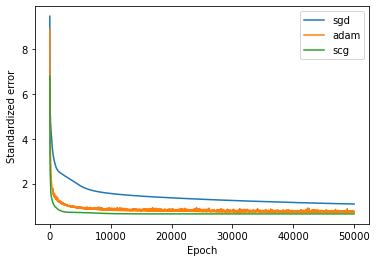

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
errors = []
n_epochs = 50000
method_rhos = [('sgd', 0.01),
               ('adam', 0.01),
               ('scg', None)]

for method, rho in method_rhos:
    nnet = nn.NeuralNetwork(Xtrain.shape[1], [10,10], 1)
    nnet.train(Xtrain, Ttrain, n_epochs, method=method, learning_rate=rho, verbose=False)
    Ytrain = nnet.use(Xtrain)
    Ytest = nnet.use(Xtest)
    rmse_train = rmse(Ttrain, Ytrain)
    rmse_test = rmse(Ttest, Ytest)
    print( 'method = ', method, '\nRMSE train value = ', rmse_train, '\nRMSE test value = ', rmse_test, '\n')
    errors.append(nnet.get_error_trace())
    
plt.figure(2)
plt.clf()
for error_trace in errors:
    plt.plot(error_trace)
plt.xlabel('Epoch')
plt.ylabel('Standardized error')
plt.legend([mr[0] for mr in method_rhos]);

#This is our base case with parameters : list of hidden layers with number of neurons [10,10], n_epochs = 50000, learning rate = 0.01

Iteration 2 : Increasing n_epochs to 75000

sgd: Epoch 7500 ObjectiveF=1.83941
sgd: Epoch 15000 ObjectiveF=1.50073
sgd: Epoch 22500 ObjectiveF=1.36723
sgd: Epoch 30000 ObjectiveF=1.26985
sgd: Epoch 37500 ObjectiveF=1.19781
sgd: Epoch 45000 ObjectiveF=1.13180
sgd: Epoch 52500 ObjectiveF=1.07776
sgd: Epoch 60000 ObjectiveF=1.03890
sgd: Epoch 67500 ObjectiveF=1.00499
sgd: Epoch 75000 ObjectiveF=0.97685
method =  sgd 
RMSE train value =  0.9768494090731864 
RMSE test value =  3.6234812250110653 

method =  adam 
RMSE train value =  0.6044820583691806 
RMSE test value =  4.777404231277743 

SCG: Epoch 7500 ObjectiveF=0.63851
SCG: Epoch 15000 ObjectiveF=0.61912
SCG: Epoch 22500 ObjectiveF=0.61770
SCG: Epoch 30000 ObjectiveF=0.61570
SCG: Epoch 37500 ObjectiveF=0.61268
SCG: Epoch 45000 ObjectiveF=0.59290
SCG: Epoch 52500 ObjectiveF=0.58839
SCG: Epoch 60000 ObjectiveF=0.58732
SCG: Epoch 67500 ObjectiveF=0.58673
SCG: Epoch 75000 ObjectiveF=0.58647
method =  scg 
RMSE train value =  0.586467763214753 
RMSE test value =  6.155864023608995 


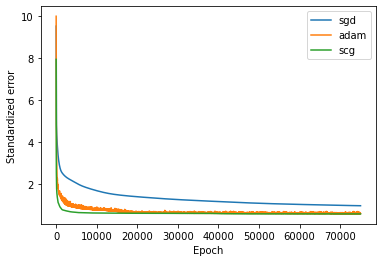

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
errors = []
n_epochs = 75000
method_rhos = [('sgd', 0.01),
               ('adam', 0.01),
               ('scg', None)]

for method, rho in method_rhos:
    nnet = nn.NeuralNetwork(Xtrain.shape[1], [10,10], 1)
    nnet.train(Xtrain, Ttrain, n_epochs, method=method, learning_rate=rho, verbose=False)
    Ytrain = nnet.use(Xtrain)
    Ytest = nnet.use(Xtest)
    rmse_train = rmse(Ttrain, Ytrain)
    rmse_test = rmse(Ttest, Ytest)
    print( 'method = ', method, '\nRMSE train value = ', rmse_train, '\nRMSE test value = ', rmse_test, '\n')
    errors.append(nnet.get_error_trace())
    
plt.figure(2)
plt.clf()
for error_trace in errors:
    plt.plot(error_trace)
plt.xlabel('Epoch')
plt.ylabel('Standardized error')
plt.legend([mr[0] for mr in method_rhos]);

Conclusion : Increasing n_epochs does not decrease training rmse value significantly. 

Iteration 3 : decreasing n_epochs to 45000

sgd: Epoch 4500 ObjectiveF=2.08597
sgd: Epoch 9000 ObjectiveF=1.65740
sgd: Epoch 13500 ObjectiveF=1.56780
sgd: Epoch 18000 ObjectiveF=1.49773
sgd: Epoch 22500 ObjectiveF=1.43318
sgd: Epoch 27000 ObjectiveF=1.37806
sgd: Epoch 31500 ObjectiveF=1.33186
sgd: Epoch 36000 ObjectiveF=1.29133
sgd: Epoch 40500 ObjectiveF=1.25971
sgd: Epoch 45000 ObjectiveF=1.23591
method =  sgd 
RMSE train value =  1.2359004300639196 
RMSE test value =  3.691407345640283 

method =  adam 
RMSE train value =  0.671702493165701 
RMSE test value =  7.305982098804393 

SCG: Epoch 4500 ObjectiveF=0.64774
SCG: Epoch 9000 ObjectiveF=0.59239
SCG: Epoch 13500 ObjectiveF=0.58436
SCG: Epoch 18000 ObjectiveF=0.58107
SCG: Epoch 22500 ObjectiveF=0.57991
SCG: Epoch 27000 ObjectiveF=0.57936
SCG: Epoch 31500 ObjectiveF=0.57881
SCG: Epoch 36000 ObjectiveF=0.57856
SCG: Epoch 40500 ObjectiveF=0.57820
SCG: Epoch 45000 ObjectiveF=0.57801
method =  scg 
RMSE train value =  0.5780091579404143 
RMSE test value =  5.098909669172011 



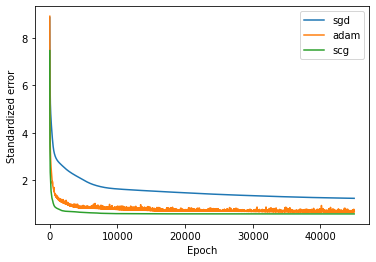

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
errors = []
n_epochs = 45000
method_rhos = [('sgd', 0.01),
               ('adam', 0.01),
               ('scg', None)]

for method, rho in method_rhos:
    nnet = nn.NeuralNetwork(Xtrain.shape[1], [10,10], 1)
    nnet.train(Xtrain, Ttrain, n_epochs, method=method, learning_rate=rho, verbose=False)
    Ytrain = nnet.use(Xtrain)
    Ytest = nnet.use(Xtest)
    rmse_train = rmse(Ttrain, Ytrain)
    rmse_test = rmse(Ttest, Ytest)
    print( 'method = ', method, '\nRMSE train value = ', rmse_train, '\nRMSE test value = ', rmse_test, '\n')
    errors.append(nnet.get_error_trace())
    
plt.figure(2)
plt.clf()
for error_trace in errors:
    plt.plot(error_trace)
plt.xlabel('Epoch')
plt.ylabel('Standardized error')
plt.legend([mr[0] for mr in method_rhos]);

Conclusion : A lower value for n_epochs reduces the computational load without any signicant decrease in training rmse value.

Iteration 4 : keeping n_epochs = 45000 and network structure = [10,10] constant; and increasing the learning rate = 0.1

sgd: Epoch 4500 ObjectiveF=2.03433
sgd: Epoch 9000 ObjectiveF=1.77305
sgd: Epoch 13500 ObjectiveF=1.61766
sgd: Epoch 18000 ObjectiveF=1.50981
sgd: Epoch 22500 ObjectiveF=1.41185
sgd: Epoch 27000 ObjectiveF=1.35600
sgd: Epoch 31500 ObjectiveF=1.31969
sgd: Epoch 36000 ObjectiveF=1.28210
sgd: Epoch 40500 ObjectiveF=1.24036
sgd: Epoch 45000 ObjectiveF=1.19987
method =  sgd 
RMSE train value =  1.1998603880920469 
RMSE test value =  5.311541356840774 

method =  adam 
RMSE train value =  0.8912772427684804 
RMSE test value =  5.377701343589743 

SCG: Epoch 4500 ObjectiveF=0.78187
SCG: Epoch 9000 ObjectiveF=0.74304
SCG: Epoch 13500 ObjectiveF=0.71022
SCG: Epoch 18000 ObjectiveF=0.69191
SCG: Epoch 22500 ObjectiveF=0.68044
SCG: Epoch 27000 ObjectiveF=0.67845
SCG: Epoch 31500 ObjectiveF=0.67732
SCG: Epoch 36000 ObjectiveF=0.67696
SCG: Epoch 40500 ObjectiveF=0.67654
SCG: Epoch 45000 ObjectiveF=0.67584
method =  scg 
RMSE train value =  0.675844128291214 
RMSE test value =  8.622747809011237 



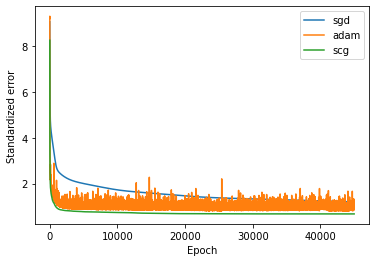

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
errors = []
n_epochs = 45000
method_rhos = [('sgd', 0.1),
               ('adam', 0.1),
               ('scg', None)]

for method, rho in method_rhos:
    nnet = nn.NeuralNetwork(Xtrain.shape[1], [10,10], 1)
    nnet.train(Xtrain, Ttrain, n_epochs, method=method, learning_rate=rho, verbose=False)
    Ytrain = nnet.use(Xtrain)
    Ytest = nnet.use(Xtest)
    rmse_train = rmse(Ttrain, Ytrain)
    rmse_test = rmse(Ttest, Ytest)
    print( 'method = ', method, '\nRMSE train value = ', rmse_train, '\nRMSE test value = ', rmse_test, '\n')
    errors.append(nnet.get_error_trace())
    
plt.figure(2)
plt.clf()
for error_trace in errors:
    plt.plot(error_trace)
plt.xlabel('Epoch')
plt.ylabel('Standardized error')
plt.legend([mr[0] for mr in method_rhos]);

Conclusion : An increase in learning rate causes the adam algorithm to hunt for the local minima

Iteration 5 : Decreasing the value of learning rate = 0.001

sgd: Epoch 4500 ObjectiveF=1.97688
sgd: Epoch 9000 ObjectiveF=1.63545
sgd: Epoch 13500 ObjectiveF=1.51642
sgd: Epoch 18000 ObjectiveF=1.44798
sgd: Epoch 22500 ObjectiveF=1.39165
sgd: Epoch 27000 ObjectiveF=1.32643
sgd: Epoch 31500 ObjectiveF=1.27021
sgd: Epoch 36000 ObjectiveF=1.23563
sgd: Epoch 40500 ObjectiveF=1.21250
sgd: Epoch 45000 ObjectiveF=1.19189
method =  sgd 
RMSE train value =  1.1918900725120583 
RMSE test value =  6.3878915951537865 

method =  adam 
RMSE train value =  0.6578244857865632 
RMSE test value =  10.93236354496048 

SCG: Epoch 4500 ObjectiveF=0.66985
SCG: Epoch 9000 ObjectiveF=0.64368
SCG: Epoch 13500 ObjectiveF=0.62627
SCG: Epoch 18000 ObjectiveF=0.61454
SCG: Epoch 22500 ObjectiveF=0.61032
SCG: Epoch 27000 ObjectiveF=0.60304
SCG: Epoch 31500 ObjectiveF=0.59768
SCG: Epoch 36000 ObjectiveF=0.59380
SCG: Epoch 40500 ObjectiveF=0.58841
SCG: Epoch 45000 ObjectiveF=0.58154
method =  scg 
RMSE train value =  0.5815432010890126 
RMSE test value =  6.116474446664903 



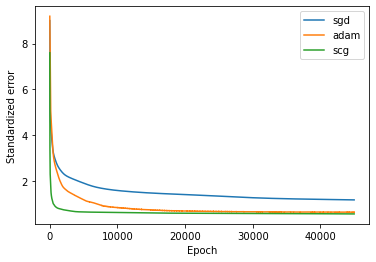

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
errors = []
n_epochs = 45000
method_rhos = [('sgd', 0.001),
               ('adam', 0.001),
               ('scg', None)]

for method, rho in method_rhos:
    nnet = nn.NeuralNetwork(Xtrain.shape[1], [10,10], 1)
    nnet.train(Xtrain, Ttrain, n_epochs, method=method, learning_rate=rho, verbose=False)
    Ytrain = nnet.use(Xtrain)
    Ytest = nnet.use(Xtest)
    rmse_train = rmse(Ttrain, Ytrain)
    rmse_test = rmse(Ttest, Ytest)
    print( 'method = ', method, '\nRMSE train value = ', rmse_train, '\nRMSE test value = ', rmse_test, '\n')
    errors.append(nnet.get_error_trace())
    
plt.figure(2)
plt.clf()
for error_trace in errors:
    plt.plot(error_trace)
plt.xlabel('Epoch')
plt.ylabel('Standardized error')
plt.legend([mr[0] for mr in method_rhos]);

Conclusion : Decreasing the value of learning rate lowers the noise in Adam algorithm and reduces the training rmse values.

Iteration 6 : Iecreasing the learning rate to 0.0001

sgd: Epoch 4500 ObjectiveF=1.87826
sgd: Epoch 9000 ObjectiveF=1.61316
sgd: Epoch 13500 ObjectiveF=1.48833
sgd: Epoch 18000 ObjectiveF=1.42863
sgd: Epoch 22500 ObjectiveF=1.38662
sgd: Epoch 27000 ObjectiveF=1.35331
sgd: Epoch 31500 ObjectiveF=1.31755
sgd: Epoch 36000 ObjectiveF=1.27693
sgd: Epoch 40500 ObjectiveF=1.23403
sgd: Epoch 45000 ObjectiveF=1.19494
method =  sgd 
RMSE train value =  1.194930965382877 
RMSE test value =  5.15445148617301 

method =  adam 
RMSE train value =  0.6896693584086324 
RMSE test value =  7.213379399488644 

SCG: Epoch 4500 ObjectiveF=0.66025
SCG: Epoch 9000 ObjectiveF=0.63845
SCG: Epoch 13500 ObjectiveF=0.62679
SCG: Epoch 18000 ObjectiveF=0.61328
SCG: Epoch 22500 ObjectiveF=0.59866
SCG: Epoch 27000 ObjectiveF=0.56735
SCG: Epoch 31500 ObjectiveF=0.56729
SCG: Epoch 36000 ObjectiveF=0.56729
method =  scg 
RMSE train value =  0.5672931566824982 
RMSE test value =  5.695650738749112 



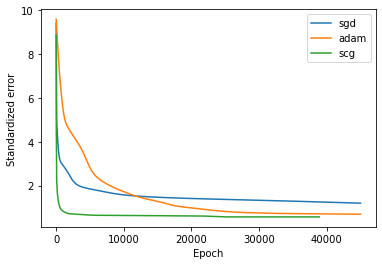

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
errors = []
n_epochs = 45000
method_rhos = [('sgd', 0.0001),
               ('adam', 0.0001),
               ('scg', None)]

for method, rho in method_rhos:
    nnet = nn.NeuralNetwork(Xtrain.shape[1], [10,10], 1)
    nnet.train(Xtrain, Ttrain, n_epochs, method=method, learning_rate=rho, verbose=False)
    Ytrain = nnet.use(Xtrain)
    Ytest = nnet.use(Xtest)
    rmse_train = rmse(Ttrain, Ytrain)
    rmse_test = rmse(Ttest, Ytest)
    print( 'method = ', method, '\nRMSE train value = ', rmse_train, '\nRMSE test value = ', rmse_test, '\n')
    errors.append(nnet.get_error_trace())
    
plt.figure(2)
plt.clf()
for error_trace in errors:
    plt.plot(error_trace)
plt.xlabel('Epoch')
plt.ylabel('Standardized error')
plt.legend([mr[0] for mr in method_rhos]);

Conclusion : Decreasing the learning rate to 0.0001 causes it to increase the training rmse values for the adam and scg algorithms slightly

Iteration 7 : keeping learning rate = 0.001 and n_epochs = 45000 constant and changing network structure to [10,10,10]

sgd: Epoch 4500 ObjectiveF=1.83703
sgd: Epoch 9000 ObjectiveF=1.62073
sgd: Epoch 13500 ObjectiveF=1.51049
sgd: Epoch 18000 ObjectiveF=1.45237
sgd: Epoch 22500 ObjectiveF=1.39428
sgd: Epoch 27000 ObjectiveF=1.34600
sgd: Epoch 31500 ObjectiveF=1.29684
sgd: Epoch 36000 ObjectiveF=1.25176
sgd: Epoch 40500 ObjectiveF=1.21798
sgd: Epoch 45000 ObjectiveF=1.18789
method =  sgd 
RMSE train value =  1.1878790630228908 
RMSE test value =  5.147814144652939 

method =  adam 
RMSE train value =  0.3647961930905514 
RMSE test value =  9.855877699463257 

SCG: Epoch 4500 ObjectiveF=0.31578
SCG: Epoch 9000 ObjectiveF=0.25054
SCG: Epoch 13500 ObjectiveF=0.23855
SCG: Epoch 18000 ObjectiveF=0.23272
SCG: Epoch 22500 ObjectiveF=0.22940
SCG: Epoch 27000 ObjectiveF=0.22264
SCG: Epoch 31500 ObjectiveF=0.21813
SCG: Epoch 36000 ObjectiveF=0.21280
SCG: Epoch 40500 ObjectiveF=0.20572
SCG: Epoch 45000 ObjectiveF=0.20063
method =  scg 
RMSE train value =  0.2006284049761152 
RMSE test value =  10.410449816173154 



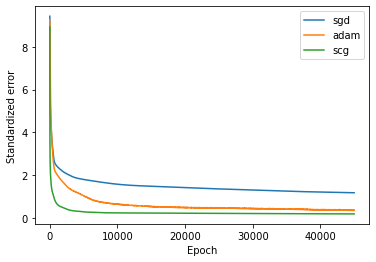

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
errors = []
n_epochs = 45000
method_rhos = [('sgd', 0.001),
               ('adam', 0.001),
               ('scg', None)]

for method, rho in method_rhos:
    nnet = nn.NeuralNetwork(Xtrain.shape[1], [10,10,10], 1)
    nnet.train(Xtrain, Ttrain, n_epochs, method=method, learning_rate=rho, verbose=False)
    Ytrain = nnet.use(Xtrain)
    Ytest = nnet.use(Xtest)
    rmse_train = rmse(Ttrain, Ytrain)
    rmse_test = rmse(Ttest, Ytest)
    print( 'method = ', method, '\nRMSE train value = ', rmse_train, '\nRMSE test value = ', rmse_test, '\n')
    errors.append(nnet.get_error_trace())
    
plt.figure(2)
plt.clf()
for error_trace in errors:
    plt.plot(error_trace)
plt.xlabel('Epoch')
plt.ylabel('Standardized error')
plt.legend([mr[0] for mr in method_rhos]);

Conclusion : Increasing the number of layers significantly lowers the training rmse values for adam and scg and slightly reduces the training rmse value for sdg algorithm.

Iteration 8 : Decreasing the number of layers to a single hidden layer network [10]

sgd: Epoch 4500 ObjectiveF=2.21993
sgd: Epoch 9000 ObjectiveF=1.93542
sgd: Epoch 13500 ObjectiveF=1.84174
sgd: Epoch 18000 ObjectiveF=1.75935
sgd: Epoch 22500 ObjectiveF=1.70309
sgd: Epoch 27000 ObjectiveF=1.67504
sgd: Epoch 31500 ObjectiveF=1.66282
sgd: Epoch 36000 ObjectiveF=1.65562
sgd: Epoch 40500 ObjectiveF=1.65065
sgd: Epoch 45000 ObjectiveF=1.64674
method =  sgd 
RMSE train value =  1.6467395055865133 
RMSE test value =  4.293269286777785 

method =  adam 
RMSE train value =  1.354105925865348 
RMSE test value =  5.280039035275706 

SCG: Epoch 4500 ObjectiveF=1.42308
SCG: Epoch 9000 ObjectiveF=1.41576
SCG: Epoch 13500 ObjectiveF=1.40908
SCG: Epoch 18000 ObjectiveF=1.39625
SCG: Epoch 22500 ObjectiveF=1.38504
SCG: Epoch 27000 ObjectiveF=1.37682
SCG: Epoch 31500 ObjectiveF=1.37345
SCG: Epoch 36000 ObjectiveF=1.37158
SCG: Epoch 40500 ObjectiveF=1.37050
SCG: Epoch 45000 ObjectiveF=1.36987
method =  scg 
RMSE train value =  1.3698663658345425 
RMSE test value =  5.051871888413733 



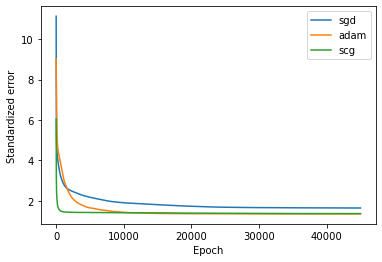

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
errors = []
n_epochs = 45000
method_rhos = [('sgd', 0.001),
               ('adam', 0.001),
               ('scg', None)]

for method, rho in method_rhos:
    nnet = nn.NeuralNetwork(Xtrain.shape[1], [10], 1)
    nnet.train(Xtrain, Ttrain, n_epochs, method=method, learning_rate=rho, verbose=False)
    Ytrain = nnet.use(Xtrain)
    Ytest = nnet.use(Xtest)
    rmse_train = rmse(Ttrain, Ytrain)
    rmse_test = rmse(Ttest, Ytest)
    print( 'method = ', method, '\nRMSE train value = ', rmse_train, '\nRMSE test value = ', rmse_test, '\n')
    errors.append(nnet.get_error_trace())
    
plt.figure(2)
plt.clf()
for error_trace in errors:
    plt.plot(error_trace)
plt.xlabel('Epoch')
plt.ylabel('Standardized error')
plt.legend([mr[0] for mr in method_rhos]);

Conclusion : Decreasing the number of layers causes the training rmse values of adam, scg and sdg to increase significantly

Iteration 9 : Increasing the number of layers to 4 [10,10,10,10]

sgd: Epoch 4500 ObjectiveF=1.40065
sgd: Epoch 9000 ObjectiveF=1.05709
sgd: Epoch 13500 ObjectiveF=0.86375
sgd: Epoch 18000 ObjectiveF=0.70003
sgd: Epoch 22500 ObjectiveF=0.57984
sgd: Epoch 27000 ObjectiveF=0.49434
sgd: Epoch 31500 ObjectiveF=0.43074
sgd: Epoch 36000 ObjectiveF=0.38385
sgd: Epoch 40500 ObjectiveF=0.34295
sgd: Epoch 45000 ObjectiveF=0.31037
method =  sgd 
RMSE train value =  0.310365140257197 
RMSE test value =  8.32341341732756 

method =  adam 
RMSE train value =  0.028072614076762627 
RMSE test value =  7.533007174450571 

SCG: Epoch 4500 ObjectiveF=0.00337
SCG: Epoch 9000 ObjectiveF=0.00008
SCG: Epoch 13500 ObjectiveF=0.00000
method =  scg 
RMSE train value =  1.0344929993885202e-06 
RMSE test value =  8.872575592319052 



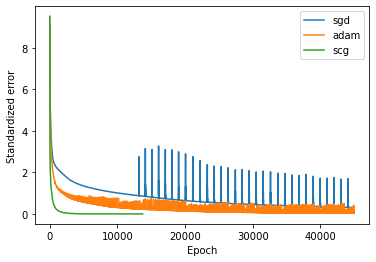

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
errors = []
n_epochs = 45000
method_rhos = [('sgd', 0.001),
               ('adam', 0.001),
               ('scg', None)]

for method, rho in method_rhos:
    nnet = nn.NeuralNetwork(Xtrain.shape[1], [30,20,15,10], 1)
    nnet.train(Xtrain, Ttrain, n_epochs, method=method, learning_rate=rho, verbose=False)
    Ytrain = nnet.use(Xtrain)
    Ytest = nnet.use(Xtest)
    rmse_train = rmse(Ttrain, Ytrain)
    rmse_test = rmse(Ttest, Ytest)
    print( 'method = ', method, '\nRMSE train value = ', rmse_train, '\nRMSE test value = ', rmse_test, '\n')
    errors.append(nnet.get_error_trace())
    
plt.figure(2)
plt.clf()
for error_trace in errors:
    plt.plot(error_trace)
plt.xlabel('Epoch')
plt.ylabel('Standardized error')
plt.legend([mr[0] for mr in method_rhos]);

Conclusion : Increasing the number of layers to 4 and increasing the number of neurons in each layers causes the training rmse value to reduce significantly in all three algorithms.

CONCLUSION : 1. As number of layers and number of neurons increases the training rmse value reduces 
                but the test rmse values increases as our model over fits our training data.
             2. As the learning rate is decreased training rmse values reduces.
             3. As the number of epochs increases training rmse values reduces slightly.

# Grading

Your notebook will be run and graded automatically. Test this grading process by first downloading [A2grader.tar](http://www.cs.colostate.edu/~anderson/cs545/notebooks/A2grader.tar) and extract `A2grader.py` from it. Run the code in the following cell to demonstrate an example grading session.  The remaining 20 points will be based on your discussion of this assignment.

A different, but similar, grading script will be used to grade your checked-in notebook. It will include additional tests. You should design and perform additional tests on all of your functions to be sure they run correctly before checking in your notebook.  

For the grading script to run correctly, you must first name this notebook as 'Lastname-A2.ipynb' with 'Lastname' being your last name, and then save this notebook.

In [3]:
%run -i A2grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Shetty-A2.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing

    import neuralnetwork as nn

    n_inputs = 3
    n_hiddens = [10, 20]
    n_outputs = 2
    n_samples = 5

    X = np.arange(n_samples * n_inputs).reshape(n_samples, n_inputs) * 0.1
    
    nnet = nn.NeuralNetwork(n_inputs, n_hiddens, n_outputs)
    nnet.all_weights = 0.1  # set all weights to 0.1
    nnet.X_means = np.mean(X, axis=0)
    nnet.X_stds = np.std(X, axis=0)
    nnet.T_means = np.zeros((n_samples, n_outputs))
    nnet.T_stds = np.ones((n_samples, n_outputs))
    
    Y = nnet.use(X)


--- 40/40 points. Returned correct value.

Testing
    n_inputs = 3
    n_hiddens = [10, 500, 6, 3]
    n_samples = 5

    X = np.arange(n_samples * n_inputs).reshape(n_samples, n_inputs) * 0.1
    T = np.log(X + 0.1)
    n_outputs = T.shape[1]

<Figure size 432x288 with 0 Axes>

# Extra Credit

Apply your multilayer neural network code to a regression problem using data that you choose 
from the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets.php). Pick a dataset that
is listed as being appropriate for regression.

In [23]:
TB = pd.read_csv('Behavior of the urban traffic of the city of Sao Paulo in Brazil.csv',delimiter=';', decimal=',', usecols=range(18), na_values=-200)
TB

,Hour (Coded),Immobilized bus,Broken Truck,Vehicle excess,Accident victim,Running over,Fire vehicles,Occurrence involving freight,Incident involving dangerous freight,Lack of electricity,Fire,Point of flooding,Manifestations,Defect in the network of trolleybuses,Tree on the road,Semaphore off,Intermittent Semaphore,Slowness in traffic (%)
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.1
1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.6
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.7
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9.2
4,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,23,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,17.8
131,24,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,18.1
132,25,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,17.7
133,26,0,4,0,0,0,0,0,0,0,0,0,1,0,0,1,0,17.4


In [15]:
#Hour (Coded);Immobilized bus;Broken Truck;Vehicle excess;Accident victim;Running over;Fire vehicles;Occurrence involving freight;Incident involving dangerous freight;Lack of electricity;Fire;Point of flooding;Manifestations;Defect in the network of trolleybuses;Tree on the road;Semaphore off;Intermittent Semaphore;Slowness in traffic (%)

X = np.array(TB[['Hour (Coded)','Immobilized bus','Broken Truck','Vehicle excess','Accident victim','Running over','Fire vehicles','Occurrence involving freight','Incident involving dangerous freight','Lack of electricity','Point of flooding','Manifestations','Defect in the network of trolleybuses','Tree on the road','Semaphore off','Intermittent Semaphore']])
T = np.array(TB[['Slowness in traffic (%)']].values)
T = T.reshape(-1,1)
Xtrain,Ttrain,Xtest,Ttest = partition(X,T,0.8)
Xtrain.shape,Ttrain.shape,Xtest.shape,Ttest.shape

((108, 16), (108, 1), (27, 16), (27, 1))

sgd: Epoch 5000 ObjectiveF=1.23203
sgd: Epoch 10000 ObjectiveF=1.15896
sgd: Epoch 15000 ObjectiveF=1.14968
sgd: Epoch 20000 ObjectiveF=1.13997
sgd: Epoch 25000 ObjectiveF=1.12469
sgd: Epoch 30000 ObjectiveF=1.11059
sgd: Epoch 35000 ObjectiveF=1.10015
sgd: Epoch 40000 ObjectiveF=1.09442
sgd: Epoch 45000 ObjectiveF=1.09093
sgd: Epoch 50000 ObjectiveF=1.08754
method =  sgd 
RMSE train value =  1.087542978576621 
RMSE test value =  6.911439544188186 

method =  adam 
RMSE train value =  0.9638509439416525 
RMSE test value =  10.64014996382921 

SCG: Epoch 5000 ObjectiveF=0.97168
SCG: Epoch 10000 ObjectiveF=0.96377
SCG: Epoch 15000 ObjectiveF=0.96365
SCG: Epoch 20000 ObjectiveF=0.96365
SCG: Epoch 25000 ObjectiveF=0.96365
SCG: Epoch 30000 ObjectiveF=0.96365
SCG: Epoch 35000 ObjectiveF=0.96365
SCG: Epoch 40000 ObjectiveF=0.96365
SCG: Epoch 45000 ObjectiveF=0.96365
SCG: Epoch 50000 ObjectiveF=0.96365
method =  scg 
RMSE train value =  0.9636527088172359 
RMSE test value =  13.355901362134244 


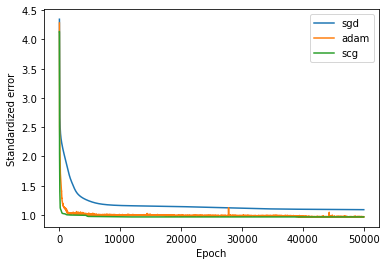

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
errors = []
n_epochs = 50000
method_rhos = [('sgd', 0.01),
               ('adam', 0.01),
               ('scg', None)]

for method, rho in method_rhos:
    nnet = nn.NeuralNetwork(Xtrain.shape[1], [10, 10], 1)
    nnet.train(Xtrain, Ttrain, n_epochs, method=method, learning_rate=rho, verbose=False)
    Ytrain = nnet.use(Xtrain)
    Ytest = nnet.use(Xtest)
    rmse_train = rmse(Ttrain, Ytrain)
    rmse_test = rmse(Ttest, Ytest)
    print( 'method = ', method, '\nRMSE train value = ', rmse_train, '\nRMSE test value = ', rmse_test, '\n')
    errors.append(nnet.get_error_trace())
    
plt.figure(2)
plt.clf()
for error_trace in errors:
    plt.plot(error_trace)
plt.xlabel('Epoch')
plt.ylabel('Standardized error')
plt.legend([mr[0] for mr in method_rhos]);